# Calculating SAM Using EOFs (Second Attempt)

This method is more closely related to the Simpson 2013 method.
- See this [notebook](/home/links/ct715/eddy_feedback/chapter1/annular_modes/old_scripts/sam_pc1_reanalysis.ipynb) for first attempt at calculations

This document has improved methods for calculating SAM:
- Weighting matrix calculation
- Vertical average, rather than 850 hPa slice

Eventual aim is reproduce this image:

[simpson2013](/home/links/ct715/eddy_feedback/chapter1/annular_modes/simpson2013_fig1.png)

... or is it? Will have to check this. At least reproducing this will prove I have calculated the zonal wind weighting, etc, correctly

In [3]:
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from eofs.xarray import Eof
import xcdat

import functions.data_wrangling as dw

In [4]:
def eof_calc_alt(data,lats):

    coslat = np.cos(np.deg2rad(lats.values)).clip(0., 1.)
    wgts = np.sqrt(coslat)[np.newaxis, np.newaxis, :]

    solver = Eof(data, weights=wgts, center=True)

    eofs = solver.eofsAsCovariance(neofs=1)
    pc1 = solver.pcs(npcs=1, pcscaling=1)

    variance_fractions = solver.varianceFraction(neigs=3)

    return eofs, pc1, variance_fractions, solver

# Winter (JJA)

In [5]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
ds = ds.sel(lat=slice(0, -90))
ds['ubar'] = ds.u.mean('lon')
ds

<xarray.Dataset> Size: 68GB
Dimensions:  (time: 21550, level: 37, lat: 37, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 172kB 1958-01-01T09:00:00 ... 2016-12-31T0...
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 0.0 -2.5 -5.0 -7.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u        (time, level, lat, lon) float32 17GB dask.array<chunksize=(30, 37, 37, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 17GB dask.array<chunksize=(30, 37, 37, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 17GB dask.array<chunksize=(30, 37, 37, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 17GB dask.array<chunksize=(30, 37, 37, 144), meta=np.ndarray>
    ubar     (time, level, lat) float32 118MB dask.array<chunksize=(30, 37, 37), meta=np.ndarray>

In [6]:
ds = ds.bounds.add_missing_bounds(axes='T')
var_anoms = ds.temporal.departures(data_var = 'ubar', freq='season', weighted=True)['ubar']

ubar_jja = var_anoms.sel(time=var_anoms.time.dt.season == 'JJA')
ubar_jja

<xarray.DataArray 'ubar' (time: 59, level: 37, lat: 37)> Size: 646kB
dask.array<getitem, shape=(59, 37, 37), dtype=float64, chunksize=(1, 37, 37), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 296B 0.0 -2.5 -5.0 -7.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 472B 1958-07-01 00:00:00 ... 2016-07-01 00:00:00
Attributes:
    operation:                temporal_avg
    mode:                     departures
    freq:                     season
    weighted:                 True
    drop_incomplete_seasons:  False
    dec_mode:                 DJF

In [7]:
eofs, pc1, variance_fractions, solver = eof_calc_alt(ubar_jja, ubar_jja.lat)

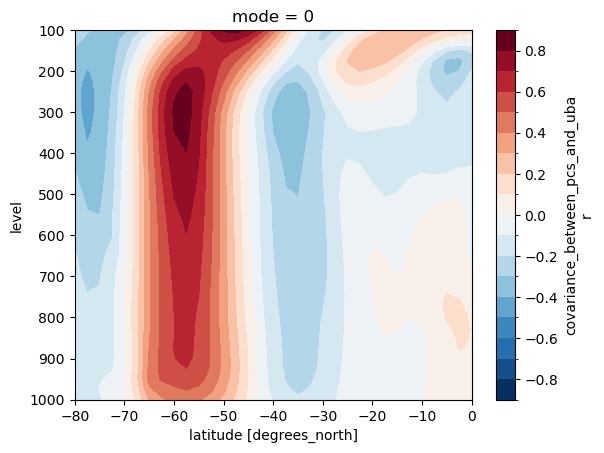

In [8]:
eofs_slice = eofs.sel(lat=slice(0,-80), level=slice(100,1000))
eofs_slice.sel(mode=0).plot.contourf(yincrease=False, levels=21)

Text(0.5, 1.0, 'EOF 1: 37.4%')

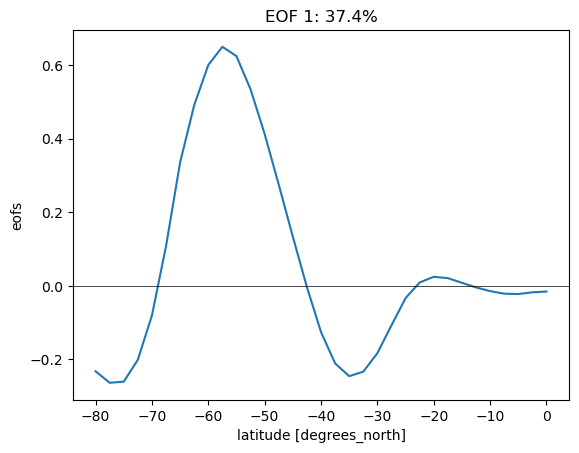

In [9]:
eofs_avg = eofs_slice.mean('level')
eofs_avg.sel(mode=0).plot.line()
plt.axhline(0, color='k', lw=0.5)
plt.title(f'EOF 1: {variance_fractions[0].values*100:.1f}%')

# Summer (DJF)

In [10]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
# ds = ds.sel(lat=slice(0,-90), time=slice('1978-11', '2011-03'))
ds = ds.sel(lat=slice(0,-90), time=slice('1958-03', '2016-11'))
ds['ubar'] = ds.u.mean('lon')
ds

<xarray.Dataset> Size: 68GB
Dimensions:  (time: 21460, level: 37, lat: 37, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 172kB 1958-03-01T09:00:00 ... 2016-11-30T0...
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 0.0 -2.5 -5.0 -7.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u        (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    ubar     (time, level, lat) float32 118MB dask.array<chunksize=(1, 37, 37), meta=np.ndarray>

In [11]:
ds = ds.bounds.add_missing_bounds(axes='T')
var_anoms = ds.temporal.departures(data_var = 'ubar', freq='season', weighted=True)['ubar']

ubar_DJF = var_anoms.sel(time=var_anoms.time.dt.season == 'DJF')
ubar_DJF

<xarray.DataArray 'ubar' (time: 59, level: 37, lat: 37)> Size: 646kB
dask.array<getitem, shape=(59, 37, 37), dtype=float64, chunksize=(1, 37, 37), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 296B 0.0 -2.5 -5.0 -7.5 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * time     (time) object 472B 1959-01-01 00:00:00 ... 2017-01-01 00:00:00
Attributes:
    operation:                temporal_avg
    mode:                     departures
    freq:                     season
    weighted:                 True
    drop_incomplete_seasons:  False
    dec_mode:                 DJF

In [12]:
eofs, pc1, variance_fractions, solver = eof_calc_alt(ubar_DJF, ubar_DJF.lat)

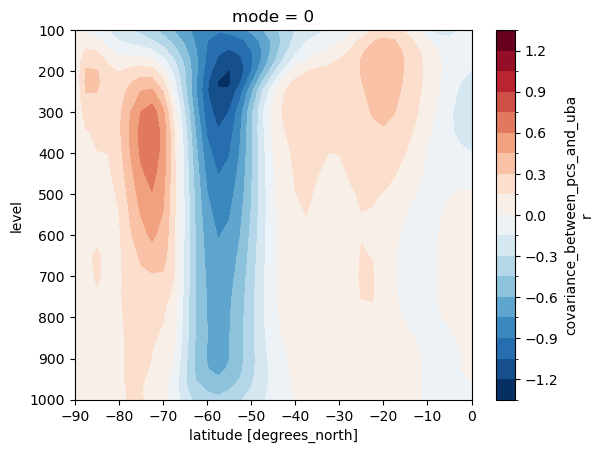

In [13]:
eofs_slice = eofs.sel(level=slice(100,1000))
eofs_slice.sel(mode=0).plot.contourf(yincrease=False, levels=21)

Text(0.5, 1.0, 'EOF 1: 35.7%')

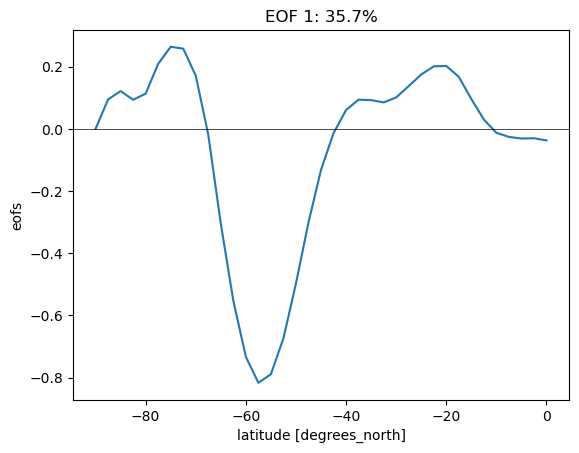

In [14]:
eofs_avg = eofs_slice.mean('level')
eofs_avg.sel(mode=0).plot.line()
plt.axhline(0, color='k', lw=0.5)
plt.title(f'EOF 1: {variance_fractions[0].values*100:.1f}%')

# Summer (DJF) day

In [15]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
ds = ds.sel(lat=slice(10,-80), time=slice('1978-11', '2011-03'))
# ds = ds.sel(lat=slice(10,-80), time=slice('1958-03', '2016-11'))
# ds['ubar'] = ds.u.mean('lon')
ds

<xarray.Dataset> Size: 37GB
Dimensions:  (time: 11839, level: 37, lat: 37, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 95kB 1978-11-01T09:00:00 ... 2011-03-31T09...
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 10.0 7.5 5.0 2.5 0.0 ... -72.5 -75.0 -77.5 -80.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u        (time, level, lat, lon) float32 9GB dask.array<chunksize=(11, 37, 37, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 9GB dask.array<chunksize=(11, 37, 37, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 9GB dask.array<chunksize=(11, 37, 37, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 9GB dask.array<chunksize=(11, 37, 37, 144), meta=np.ndarray>

In [16]:
ds = ds.bounds.add_missing_bounds(axes='T')
var_anoms = ds.temporal.departures(data_var = 'u', freq='day', weighted=True)['u'].mean('lon')
var_anoms


<xarray.DataArray 'u' (time: 11831, level: 37, lat: 37)> Size: 130MB
dask.array<mean_agg-aggregate, shape=(11831, 37, 37), dtype=float64, chunksize=(1, 37, 37), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 95kB 1978-11-01T09:00:00 ... 2011-03-31T09...
  * lat      (lat) float64 296B 10.0 7.5 5.0 2.5 0.0 ... -72.5 -75.0 -77.5 -80.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03

In [17]:
ubar_DJF = var_anoms.sel(time=var_anoms.time.dt.season == 'DJF')
ubar_DJF

<xarray.DataArray 'u' (time: 2970, level: 37, lat: 37)> Size: 33MB
dask.array<getitem, shape=(2970, 37, 37), dtype=float64, chunksize=(1, 37, 37), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 24kB 1978-12-01T09:00:00 ... 2011-02-28T09...
  * lat      (lat) float64 296B 10.0 7.5 5.0 2.5 0.0 ... -72.5 -75.0 -77.5 -80.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03

In [18]:
eofs, pc1, variance_fractions, solver = eof_calc_alt(ubar_DJF, ubar_DJF.lat)

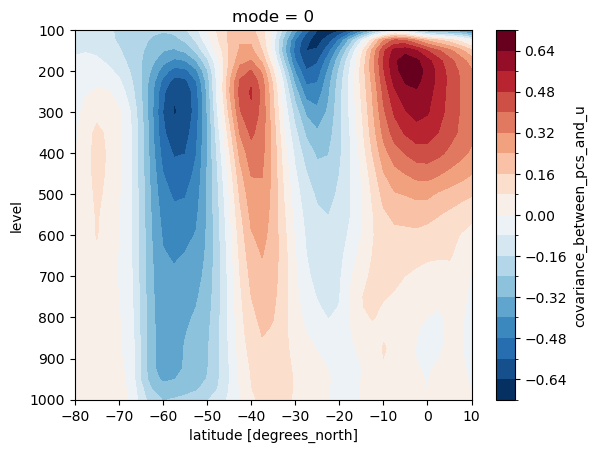

In [19]:
eofs_slice = eofs.sel(level=slice(100,1000))
eofs_slice.sel(mode=0).plot.contourf(yincrease=False, levels=21)

Text(0.5, 1.0, 'EOF 1: 36.6%')

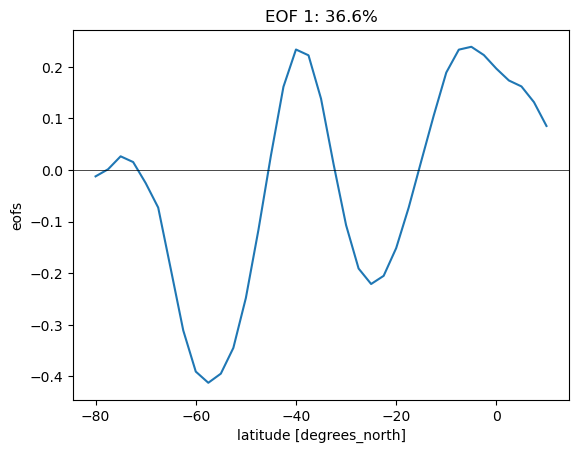

In [20]:
eofs_avg = eofs_slice.mean('level')
eofs_avg.sel(mode=0).plot.line()
plt.axhline(0, color='k', lw=0.5)
plt.title(f'EOF 1: {variance_fractions[0].values*100:.1f}%')

# Summer (DJF) day 1958-2016

In [21]:
path = '/home/links/ct715/data_storage/reanalysis/jra55_daily'
data_file = os.path.join(path, 'jra55_uvtw.nc')
ds = xr.open_mfdataset(data_file, chunks={'time': 30})
# ds = ds.sel(lat=slice(10,-80), time=slice('1978-11', '2011-03'))
ds = ds.sel(lat=slice(10,-80), time=slice('1958-03', '2016-11'))
# ds['ubar'] = ds.u.mean('lon')
ds

<xarray.Dataset> Size: 68GB
Dimensions:  (time: 21460, level: 37, lat: 37, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 172kB 1958-03-01T09:00:00 ... 2016-11-30T0...
  * lon      (lon) float64 1kB 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 296B 10.0 7.5 5.0 2.5 0.0 ... -72.5 -75.0 -77.5 -80.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    u        (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 17GB dask.array<chunksize=(1, 37, 37, 144), meta=np.ndarray>

In [22]:
ds = ds.bounds.add_missing_bounds(axes='T')
var_anoms = ds.temporal.departures(data_var = 'u', freq='day', weighted=True)['u'].mean('lon')
var_anoms


<xarray.DataArray 'u' (time: 21445, level: 37, lat: 37)> Size: 235MB
dask.array<mean_agg-aggregate, shape=(21445, 37, 37), dtype=float64, chunksize=(1, 37, 37), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 172kB 1958-03-01T09:00:00 ... 2016-11-30T0...
  * lat      (lat) float64 296B 10.0 7.5 5.0 2.5 0.0 ... -72.5 -75.0 -77.5 -80.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03

In [23]:
ubar_DJF = var_anoms.sel(time=var_anoms.time.dt.season == 'DJF')
ubar_DJF

<xarray.DataArray 'u' (time: 5220, level: 37, lat: 37)> Size: 57MB
dask.array<getitem, shape=(5220, 37, 37), dtype=float64, chunksize=(1, 37, 37), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 42kB 1958-12-01T09:00:00 ... 2016-02-28T09...
  * lat      (lat) float64 296B 10.0 7.5 5.0 2.5 0.0 ... -72.5 -75.0 -77.5 -80.0
  * level    (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03

In [24]:
eofs, pc1, variance_fractions, solver = eof_calc_alt(ubar_DJF, ubar_DJF.lat)

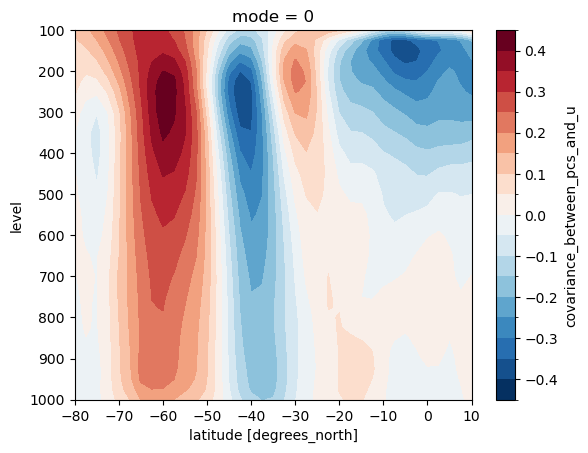

In [25]:
eofs_slice = eofs.sel(level=slice(100,1000))
eofs_slice.sel(mode=0).plot.contourf(yincrease=False, levels=21)

Text(0.5, 1.0, 'EOF 1: 33.1%')

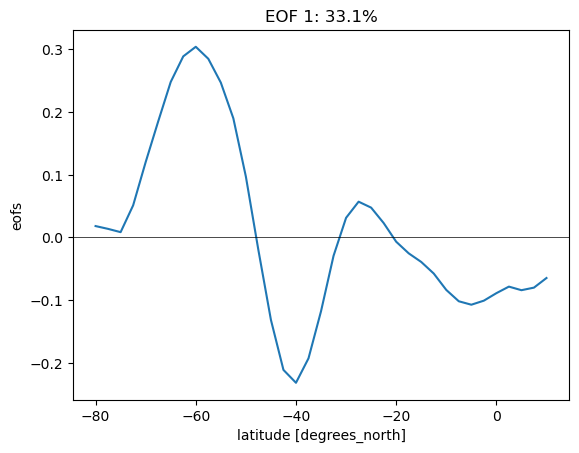

In [26]:
eofs_avg = eofs_slice.mean('level')
eofs_avg.sel(mode=0).plot.line()
plt.axhline(0, color='k', lw=0.5)
plt.title(f'EOF 1: {variance_fractions[0].values*100:.1f}%')